In [1]:
from DDPG import DDPG
from DDPG import ThreeBodyEnv
from DDPG import setup_logger_kwargs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

gymnasium is installed
mpi4py is installed


[JARVIS:35892] shmem: mmap: an error occurred while determining whether or not /var/folders/cf/x6zpxdwn2dg40q0c0r418f7c0000gp/T//ompi.JARVIS.502/jf.0/283770880/sm_segment.JARVIS.502.10ea0000.0 could be created.


trajectory.csv already exists


In [2]:
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
print(data.shape)
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

(9999, 6)


(9999, 4)

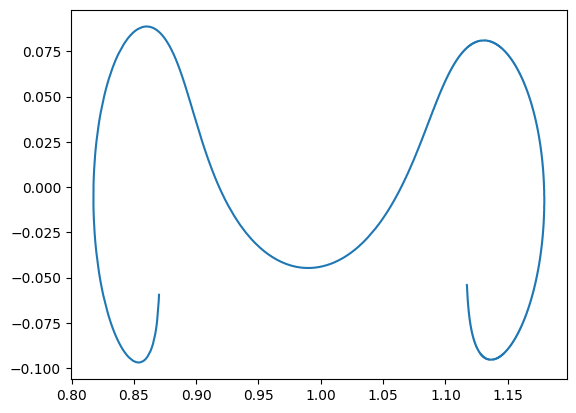

In [3]:
plt.plot(trajectory[:,0], trajectory[:,1])

Logging data to /Users/Ali/Documents/BAI/Master/Master_papers/DGDDPG/Code/DG/data/DDPG_3BP_DG/DDPG_3BP_DG_s0/progress.txt
Saving config:


1th player Number of parameters 😱😱😱: 	 pi: 4612, 	 v: 4545


2th player Number of parameters 😱😱😱: 	 pi: 4612, 	 v: 4545

Model loaded from model/actor_critic_torch_DG.pth 🔥😎😌🥰
(9999, 6)
done 🥺


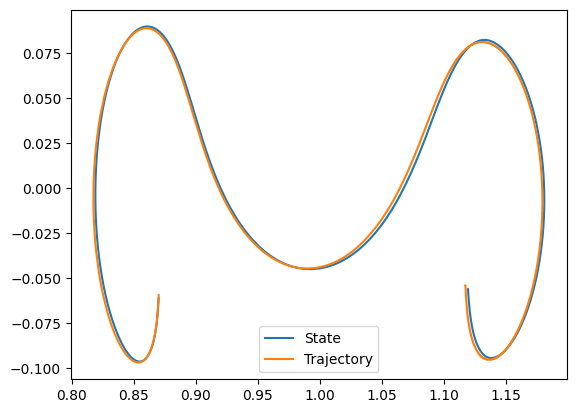

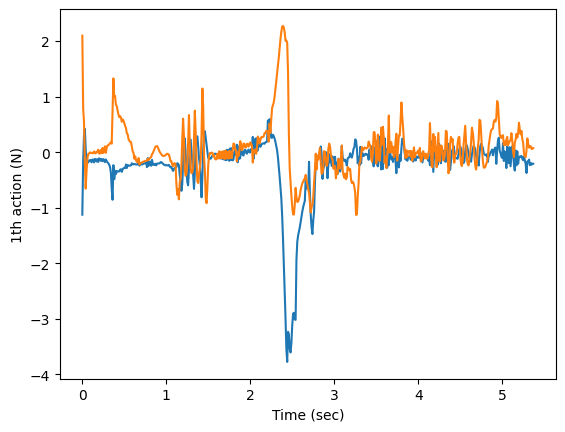

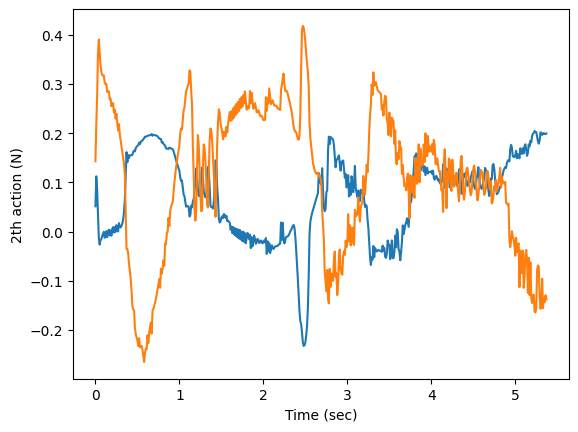

In [4]:
# Define constants
HID = 64
L = 2
GAMMA = 0.99
SEED = 0
STEPS = 4000
EPOCHS = 2000
EXP_NAME = 'DDPG_3BP_DG'

logger_kwargs = setup_logger_kwargs(EXP_NAME, SEED)

DDPG_DG = DDPG(ThreeBodyEnv(trajectory), ac_kwargs=dict(hidden_sizes=[HID] * L), gamma=GAMMA,
            seed=SEED, steps_per_epoch=STEPS, logger_kwargs=logger_kwargs)

DDPG_DG.load()
DDPG_DG.env.error_range = 0.004
DDPG_DG.env.final_range = 0.004

# test DDPG agent (not trained)
DDPG_DG.test(deterministic=True)

Logging data to /Users/Ali/Documents/BAI/Master/Master_papers/DGDDPG/Code/DG/data/DDPG_3BP_DG/DDPG_3BP_DG_s0/progress.txt
Saving config:


1th player Number of parameters 😱😱😱: 	 pi: 4612, 	 v: 4545


2th player Number of parameters 😱😱😱: 	 pi: 4612, 	 v: 4545

Model loaded from model/actor_critic_torch.pth 🔥😎😌🥰
(9999, 6)
done 🥺


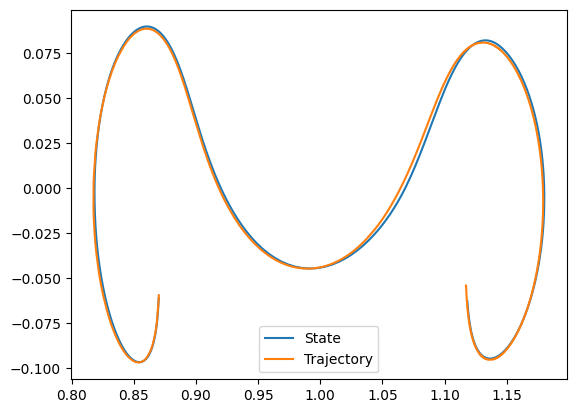

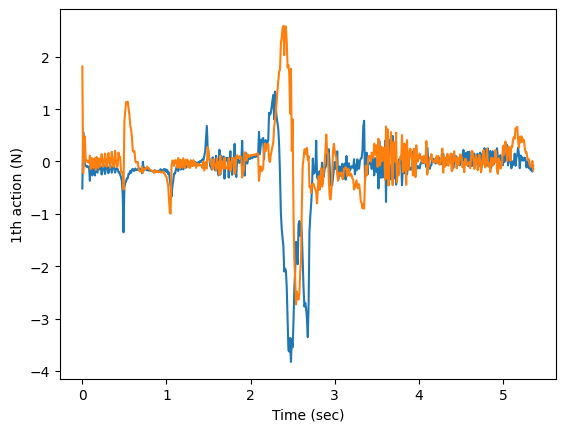

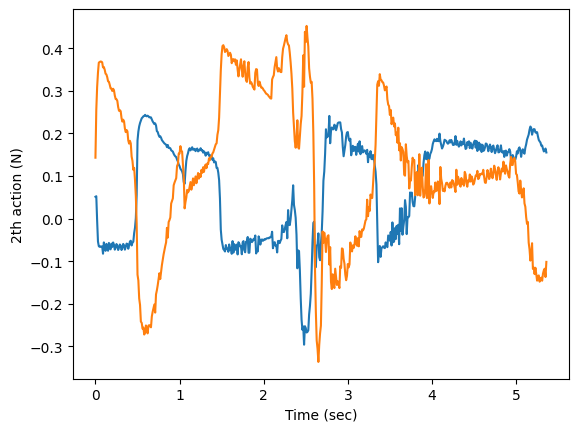

In [6]:
DDPG_ = DDPG(ThreeBodyEnv(trajectory), ac_kwargs=dict(hidden_sizes=[HID] * L), gamma=GAMMA,
            seed=SEED, steps_per_epoch=STEPS, logger_kwargs=logger_kwargs)

DDPG_.load(filepath='model/actor_critic_torch.pth')

# test DDPG agent (not trained)
DDPG_.test(deterministic=True)